# Alzheimer MRI images data notebook 
Data provided by Martin Closter Jespersen from Deloitte Consulting

## About the data 
The data was generated from a real patient cohort of MRI images both with and without alzheimer. The real images are in the dimension of 128x128 and consists of the following distribution (i.e. real distribution):
- 2560 Non alzheimer
- 1792 Very mild alzheimer 
- 717  Mild alzheimer
- 52   Moderate alzheimer

You are provided an evenly distributed synthetic dataset of ~3000 128x128 synthetic MRI images of each class. 

The data was generated using a simple (non state-of-the-art) <b>Conditional Generative Adversial Network (cGAN)</b>. cGANs are generally data hungry and considering this small dataset with great class imbalance, the data quality can be <u><b>limited</b></u>. Though image applications of machine learning has developed far, creating diverse synthetic images is still the main bottleneck. More sophisticated methods have improved this substantially but was not used here due to time and dataset size.

Reading material:
* Analysis of using GANs to replace real biomedical images in classification https://arxiv.org/pdf/1904.08688.pdf
* Synthetic COVID X ray images https://arxiv.org/pdf/2009.12478.pdf
* Synthetizing chest X ray images for model development https://www.researchgate.net/publication/328945795_Synthesizing_Chest_X-Ray_Pathology_for_Training_Deep_Convolutional_Neural_Networks


Investigate how the data can be useful!  

# Exploratory data analysis:

## Import libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import random
from collections import Counter
import imagehash
try:
    import Image
except ImportError:
    from PIL import Image
    
import torch
import torch.nn as nn
#from utils import load_state_dict_from_url
from typing import Any
import torchvision
from torch.utils.data import Dataset, TensorDataset
import time
#train
import torch.optim as optim
from sklearn import metrics
from torchvision import *


Matplotlib created a temporary config/cache directory at /tmp/matplotlib-lijn8y5o because the default path (/home/mihalis/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


## Loading in the images

In [2]:
# Each file is named <image_id>_<class_index>.png, where index 0 would be class 'Non'
class_labels = ['Non','VeryMild', 'Mild', 'Moderate']

In [2]:
# How to load the images in (to load the real dataset, follow the same approach for the appropiate folder)
synthetic_folder = 'SyntheticDatasetV33'
real_folder = 'RealDataset'
test_folder = 'RealTestdataset'
folders = [real_folder,synthetic_folder,test_folder]

fake_images = []
fake_labels = []
real_images = []
real_labels = []
test_images = []
test_labels = []
train_images = []
train_labels = []
for i,folder in enumerate(folders):
    images = []
    labels = []
    image_hashes = []
    for image_name in os.listdir(folder):
        img_path = '{}/{}'.format(folder,image_name)
        # Catch label from name
        label = image_name[-5]

        # Artifact from macOS
        if image_name == '.DS_Store': 
            continue

        im = np.array(Image.open(img_path))
        #current_hash = imagehash.phash(Image.open(img_path),hash_size=14)
        #if current_hash not in image_hashes:
        images.append(im)
        labels.append(int(label))
        #image_hashes.append(current_hash)
    
    images = np.array(images)
    labels = np.array(labels)
    print(i)
    if i==0:
        real_images = images
        real_labels = labels
    elif i==1:
        fake_images = images
        fake_labels = labels
    else:
        test_images = images
        test_labels = labels
    
train_images = np.append(real_images, fake_images, axis=0)
train_labels = np.append(real_labels, fake_labels, axis=0)

0
1
2


In [18]:
train_labels.shape

(17121,)

In [14]:
# How to load the images in (to load the real dataset, follow the same approach for the appropiate folder)
synthetic_folder = 'SyntheticDatasetV2'
real_folder = 'RealDataset'
folders = [real_folder,synthetic_folder]

fake_images = []
fake_labels = []
real_images = []
real_labels = []
for i,folder in enumerate(folders):
    images = []
    labels = []
    image_hashes = []
    for image_name in os.listdir(folder):
        img_path = '{}/{}'.format(folder,image_name)
        # Catch label from name
        label = image_name[-5]

        # Artifact from macOS
        if image_name == '.DS_Store': 
            continue

        im = np.array(Image.open(img_path))
        #current_hash = imagehash.phash(Image.open(img_path),hash_size=14)
        #if current_hash not in image_hashes:
            images.append(im)
            labels.append(int(label))
            image_hashes.append(current_hash)
    
    images = np.array(images)
    labels = np.array(labels)
    if i ==0:
        real_images = images
        real_labels = labels
    else:
        fake_images = images
        fake_labels = labels


KeyboardInterrupt: 

In [ ]:
fig, ax = plt.subplots(figsize=(16, 10))

number_of_classes = 4
bin_name = [i for i in range(number_of_classes)]
ind = np.array(bin_name)
width = np.array([1 for _ in range(number_of_classes)])
ax.set_xticks(ind + width / 2)
#bins = [class_labels[i] for i in range(number_of_classes)]
ax.hist(
    [ real_labels, fake_labels],
    bins=np.arange(number_of_classes + 1),
    alpha=0.7,
    label=[ "Real After", "Fake After"],
)
#ax.set_xticklabels(bins, rotation=45, rotation_mode="anchor", ha="right")

plt.xticks(fontsize=14)
plt.legend(loc="best", shadow=True, fontsize="x-large")
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(16, 10))

number_of_classes = 4
bin_name = [i for i in range(number_of_classes)]
ind = np.array(bin_name)
width = np.array([1 for _ in range(number_of_classes)])
ax.set_xticks(ind + width / 2)
#bins = [class_labels[i] for i in range(number_of_classes)]
ax.hist(
    [old_real_labels, old_fake_labels],
    bins=np.arange(number_of_classes + 1),
    alpha=0.7,
    label=["Real Before", "Fake Before"],
)
#ax.set_xticklabels(bins, rotation=45, rotation_mode="anchor", ha="right")

plt.xticks(fontsize=14)
plt.legend(loc="best", shadow=True, fontsize="x-large")
plt.show()

In [17]:
len(real_images),len(fake_images),len(fake_labels)

(5121, 12000, 12000)

In [18]:
Counter(fake_labels).keys(),list(Counter(fake_labels).values())

(dict_keys([2, 3, 1, 0]), [2900, 3023, 3030, 3047])

In [22]:
def group_images(real_images,real_labels,fake_images,fake_labels):
    real_clean = []
    real_moderate = []
    real_mild = []
    real_verymild = []
    fake_clean = []
    fake_moderate = []
    fake_mild = []
    fake_verymild = []
    for i,label in enumerate(real_labels):
        if label == 0:
            real_clean.append(real_images[i])
        if label == 1:
            real_verymild.append(real_images[i])
        if label == 2:
            real_mild.append(real_images[i])
        if label == 3:
            real_moderate.append(real_images[i])
    for i,label in enumerate(fake_labels):
        if label == 0:
            fake_clean.append(fake_images[i])
        if label == 1:
            fake_verymild.append(fake_images[i])
        if label == 2:
            fake_mild.append(fake_images[i])
        if label == 3:
            fake_moderate.append(fake_images[i])
    #assert len(real_clean) == 2560
    #assert len(real_verymild) == 1792
    #assert len(real_mild) == 717
    #assert len(real_moderate) == 52
    
    real_clean = np.array(real_clean)
    real_moderate = np.array(real_moderate)
    real_mild = np.array(real_mild) 
    real_verymild = np.array(real_verymild)
    fake_clean = np.array(fake_clean)
    fake_moderate = np.array(fake_moderate)
    fake_mild = np.array(fake_mild)
    fake_verymild = np.array(fake_verymild)
    dataset = [real_clean,real_verymild,real_mild,real_moderate,fake_clean,fake_verymild,fake_mild,fake_moderate]
    return dataset

def sample_images(dataset):
    numbers = []
    numbers.append(random.randint(0,len(dataset[0])))
    numbers.append(random.randint(0,len(dataset[1])))
    numbers.append(random.randint(0,len(dataset[2])))
    numbers.append(random.randint(0,len(dataset[3])))
    numbers.append(random.randint(0,len(dataset[4])))
    numbers.append(random.randint(0,len(dataset[5])))
    numbers.append(random.randint(0,len(dataset[6])))
    numbers.append(random.randint(0,len(dataset[7])))

    
    return numbers

In [23]:
dataset = group_images(real_images,real_labels,fake_images,fake_labels)
random_numbers = sample_images(dataset)

In [24]:
len(dataset[4])

3047

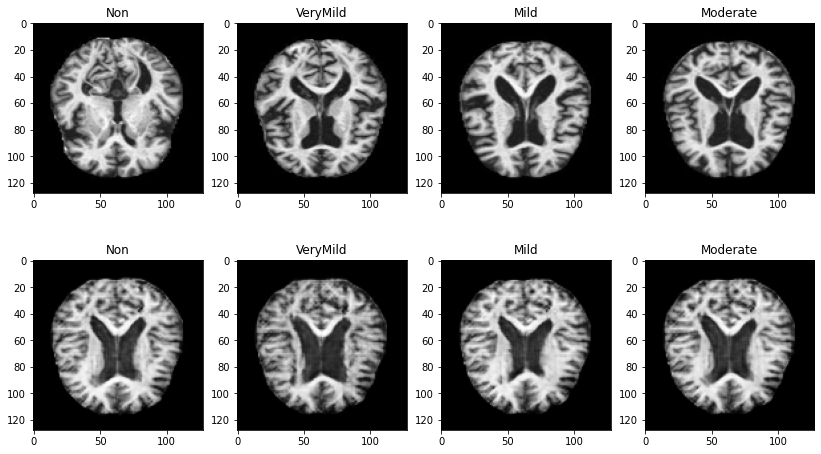

In [164]:
# Show image 
plt.rcParams["figure.figsize"] = (14,8)
random_numbers = sample_images(dataset)
fig, axs = plt.subplots(2, 4)
for i in range(8):
    
    axs[int(i/4),i%4].imshow(dataset[i][random_numbers[i], :, :, ], cmap='gray')
    axs[int(i/4),i%4].set_title(class_labels[i%4])
plt.show()


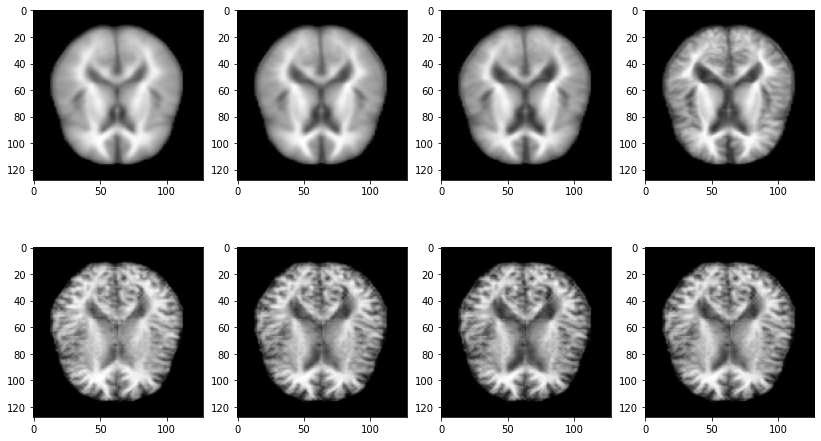

In [26]:
fig, axs = plt.subplots(2, 4)
for i,category_image in enumerate(dataset):
    place = 241+i
    plt.subplot(place)
    plt.imshow(category_image.mean(axis=0)[:,:], cmap='gray')
plt.show()

In [27]:
#TODO: min max norm instead of linalg
mean_values = []
for category_image in dataset:
    mean_values.append(category_image.mean(axis=0)/255)
    

In [28]:
def heatmap2d(vector_arrays1, vector_arrays2):
    fig = plt.figure(figsize=(20, 8))
    from mpl_toolkits.axes_grid1 import make_axes_locatable

    ax = fig.add_subplot(121)
    im = ax.imshow(vector_arrays1, cmap="viridis", interpolation="None")
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(im, cax=cax, orientation="vertical")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax2 = fig.add_subplot(122)
    im2 = ax2.imshow(vector_arrays2, cmap="viridis", interpolation="None")
    divider = make_axes_locatable(ax2)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(im2, cax=cax, orientation="vertical")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    fig.suptitle("Heatmaps for doc Embeddings", fontsize=24)

    plt.show()

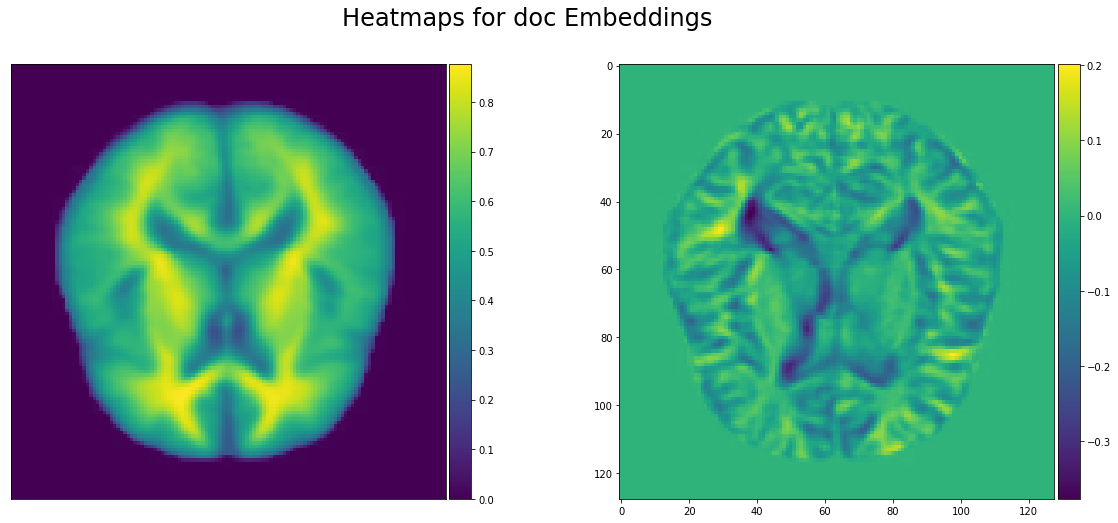

In [29]:
heatmap2d(mean_values[0],(mean_values[3]-mean_values[0]))

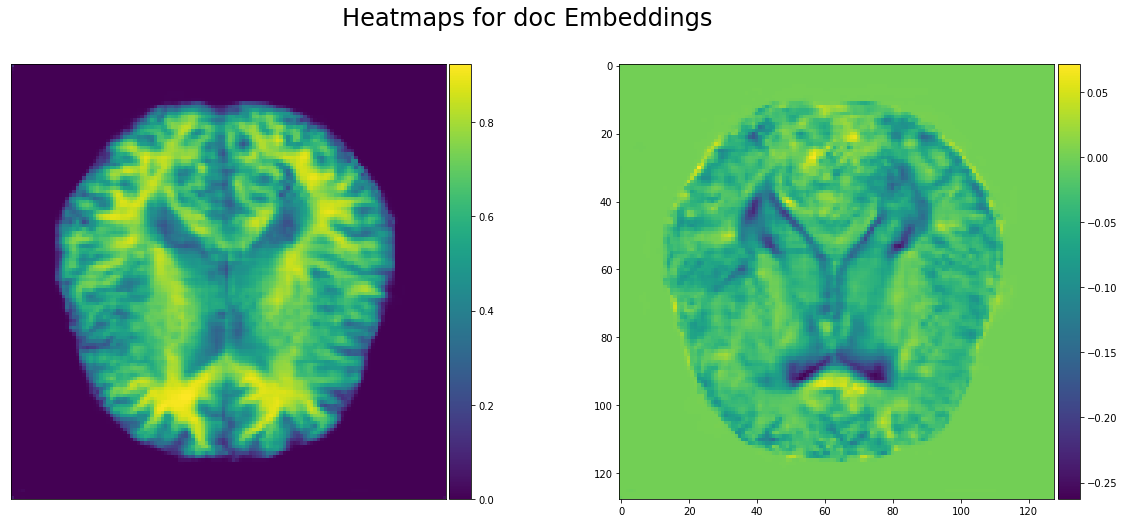

In [30]:
heatmap2d(mean_values[4],(mean_values[7]-mean_values[4]))

In [31]:
with_without = []
for i,category_image in enumerate(mean_values):
    if i % 4 ==0:
        with_without.append(category_image)
    elif i % 4 == 1:
        with_without.append(((mean_values[i]+mean_values[i+1]+mean_values[i+2])/3 ))
    else:
        pass

In [32]:
def heatmap4d(vector_arrays1, vector_arrays2,arr3,arr4):
    fig = plt.figure(figsize=(14, 14))
    from mpl_toolkits.axes_grid1 import make_axes_locatable

    ax = fig.add_subplot(221)
    im = ax.imshow(vector_arrays1, cmap="viridis", interpolation="None")
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(im, cax=cax, orientation="vertical")
    ax.get_xaxis().set_visible(False)
    #ax.get_yaxis().set_visible(False)
    ax.set_title('Healthy MRI',fontsize=28)
    ax.set_ylabel('Real', fontsize=28)   # relative to plt.rcParams['font.size']

    ax2 = fig.add_subplot(222)
    im2 = ax2.imshow(vector_arrays2, cmap="viridis", interpolation="None")
    divider = make_axes_locatable(ax2)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(im2, cax=cax, orientation="vertical")
    ax2.get_xaxis().set_visible(False)
    ax2.get_yaxis().set_visible(False)
    #ax2.title.set_text('Alzheimer Impact')
    #ax2.set_xlabel('Alzheimer Impact',fontsize=32)
    ax2.set_title('Alzheimer Impact',fontsize=28)
    
    ax3 = fig.add_subplot(223)
    im3 = ax3.imshow(arr3, cmap="viridis", interpolation="None")
    divider = make_axes_locatable(ax3)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(im3, cax=cax, orientation="vertical")
    ax3.get_xaxis().set_visible(False)
    #ax3.get_yaxis().set_visible(False)
    ax3.set_ylabel('Synthetic', fontsize=28)   # relative to plt.rcParams['font.size']

    ax4 = fig.add_subplot(224)
    im4 = ax4.imshow(arr4, cmap="viridis", interpolation="None")
    divider = make_axes_locatable(ax4)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(im4, cax=cax, orientation="vertical")
    ax4.get_xaxis().set_visible(False)
    ax4.get_yaxis().set_visible(False)
    
    plt.setp(ax3, xlabel='Synthetic Data')

    plt.show()

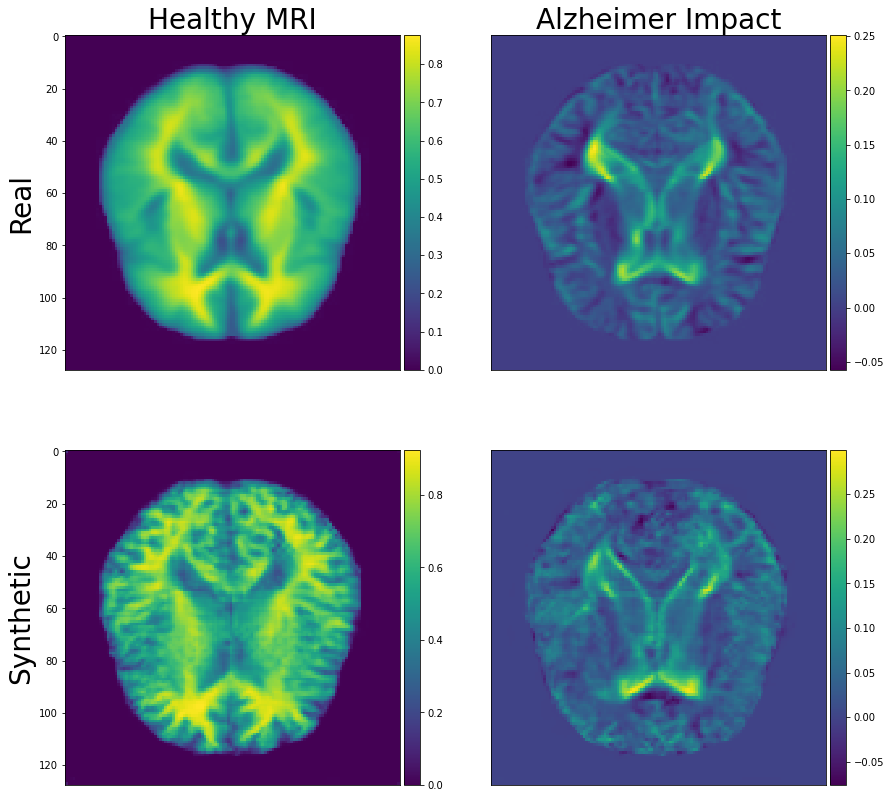

In [33]:
heatmap4d(with_without[0],with_without[0]-with_without[1],with_without[2],with_without[2]-with_without[3])

In [35]:
from sklearn.decomposition import PCA


In [36]:
for_pca = []
for aray in dataset[0]:
    for_pca.append(aray.flatten())

In [37]:
faces_pca = PCA(n_components=3)
faces_pca.fit(for_pca)

PCA(n_components=3)

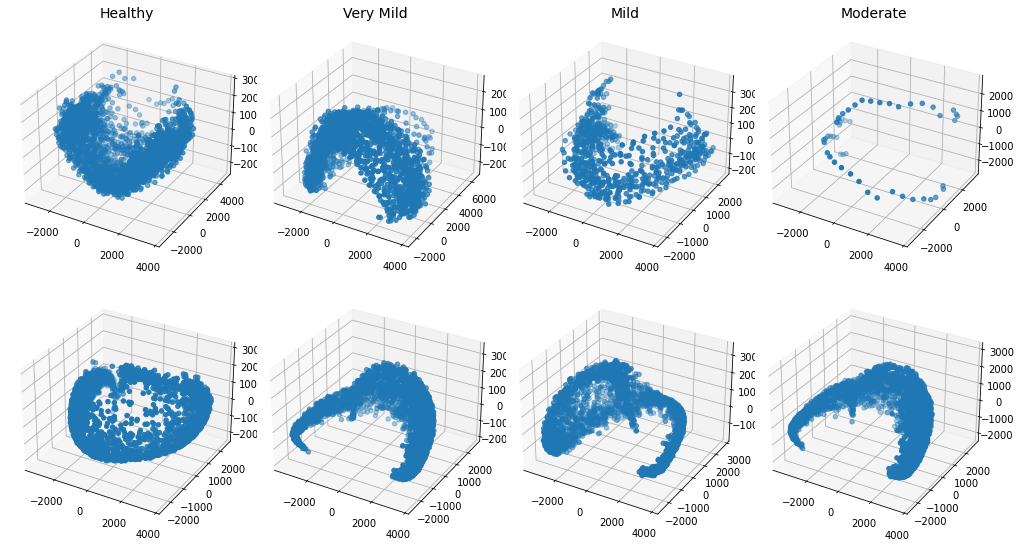

In [39]:
# Store results of PCA in a data frame
import pandas as pd
fig = plt.figure()
titles = ['Healthy',"Very Mild",'Mild','Moderate']
yt = ['Real','Synthetic']
for i,category in enumerate(dataset):
    for_pca = []
    for aray in category:
        for_pca.append(aray.flatten())
        
    faces_pca = PCA(n_components=3)
    faces_pca.fit(for_pca)
    result=pd.DataFrame(faces_pca.transform(for_pca), columns=['PCA%i' % i for i in range(3)])
    plot_number = 241+i
    # Plot initialisation
    ax = fig.add_subplot(plot_number, projection='3d')
    ax.scatter(result['PCA0'], result['PCA1'], result['PCA2'], cmap="Set2_r", s=20)
    if i < 4:
        ax.set_title(titles[i],fontsize=14)
fig.tight_layout()

plt.show()


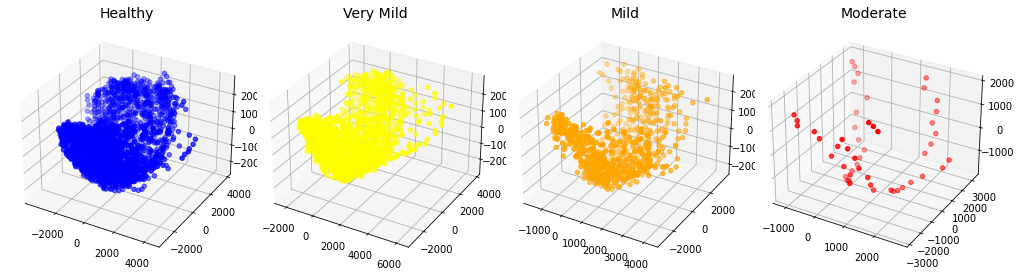

In [42]:
import pandas as pd
fig = plt.figure()
titles = ['Healthy',"Very Mild",'Mild','Moderate']
yt = ['Real','Synthetic']

for_pca = []
for aray in real_images:
    for_pca.append(aray.flatten())

faces_pca = PCA(n_components=3)
faces_pca.fit(for_pca)
projections = faces_pca.transform(for_pca)
prj_no =[]
prj_very = []
prj_mild = []
prj_mod = []
for i,proj in enumerate(projections):
    if real_labels[i] == 0:
        prj_no.append(proj)
    elif real_labels[i] == 1:
        prj_very.append(proj)
    elif real_labels[i] == 2:
        prj_mild.append(proj)
    else:
        prj_mod.append(proj)
to_plot = [np.array(prj_no),np.array(prj_very),np.array(prj_mild),np.array(prj_mod)]  
colors = ['blue','yellow','orange','red']
size = [15,20,30,60]
for i,plot in enumerate(to_plot):
                       
    result=pd.DataFrame(plot, columns=['PCA%i' % i for i in range(3)])
    plot_number = 141+i
    # Plot initialisation
    ax = fig.add_subplot(plot_number, projection='3d')
    ax.scatter(result['PCA1'], result['PCA0'], result['PCA2'],color=colors[i], cmap="Set2_r", s=20)
    if i < 4:
        ax.set_title(titles[i],fontsize=14)
fig.tight_layout()

plt.show()

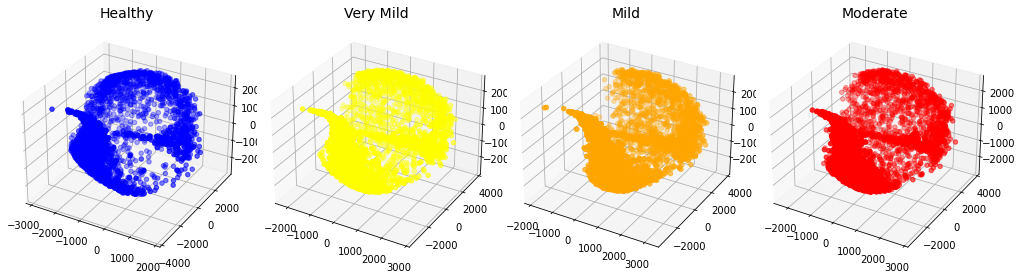

In [54]:
import pandas as pd
fig = plt.figure()
titles = ['Healthy',"Very Mild",'Mild','Moderate']
yt = ['Real','Synthetic']

for_pca = []
for aray in fake_images:
    for_pca.append(aray.flatten())

faces_pca = PCA(n_components=3)
faces_pca.fit(for_pca)
projections = faces_pca.transform(for_pca)
prj_no =[]
prj_very = []
prj_mild = []
prj_mod = []
for i,proj in enumerate(projections):
    if fake_labels[i] == 0:
        prj_no.append(proj)
    elif fake_labels[i] == 1:
        prj_very.append(proj)
    elif fake_labels[i] == 2:
        prj_mild.append(proj)
    else:
        prj_mod.append(proj)
to_plot = [np.array(prj_no),np.array(prj_very),np.array(prj_mild),np.array(prj_mod)]

for i,plot in enumerate(to_plot):
                       
    result=pd.DataFrame(plot, columns=['PCA%i' % i for i in range(3)])
    plot_number = 141+i
    # Plot initialisation
    ax = fig.add_subplot(plot_number, projection='3d')
    ax.scatter(result['PCA2'], result['PCA0'], -result['PCA1'],color=colors[i], cmap="Set2_r", s=20)
    if i < 4:
        ax.set_title(titles[i],fontsize=14)
fig.tight_layout()

plt.show()

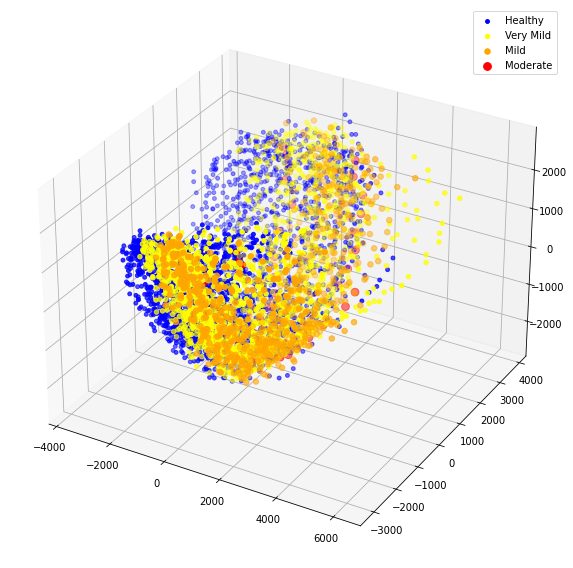

In [46]:
import pandas as pd
fig = plt.figure()
titles = ['Healthy',"Very Mild",'Mild','Moderate']
yt = ['Real','Synthetic']

for_pca = []
for aray in real_images:
    for_pca.append(aray.flatten())

faces_pca = PCA(n_components=3)
faces_pca.fit(for_pca)
projections = faces_pca.transform(for_pca)
prj_no =[]
prj_very = []
prj_mild = []
prj_mod = []
for i,proj in enumerate(projections):
    if real_labels[i] == 0:
        prj_no.append(proj)
    elif real_labels[i] == 1:
        prj_very.append(proj)
    elif real_labels[i] == 2:
        prj_mild.append(proj)
    else:
        prj_mod.append(proj)
to_plot = [np.array(prj_no),np.array(prj_very),np.array(prj_mild),np.array(prj_mod)]   
ax = fig.add_subplot(111, projection='3d')
colors = ['blue','yellow','orange','red']
size = [15,20,30,60]
for i,plot in enumerate(to_plot):
                       
    result=pd.DataFrame(plot, columns=['PCA%i' % i for i in range(3)])
    #plot_number = 141+i
    # Plot initialisation
    ax.scatter3D(result['PCA1'], result['PCA0'], result['PCA2'],color=colors[i],label=titles[i], cmap="Set2_r", s=size[i])
    #if i < 4:
        #ax.set_title(titles[i],fontsize=14)
ax.legend()

fig.tight_layout()

plt.show()

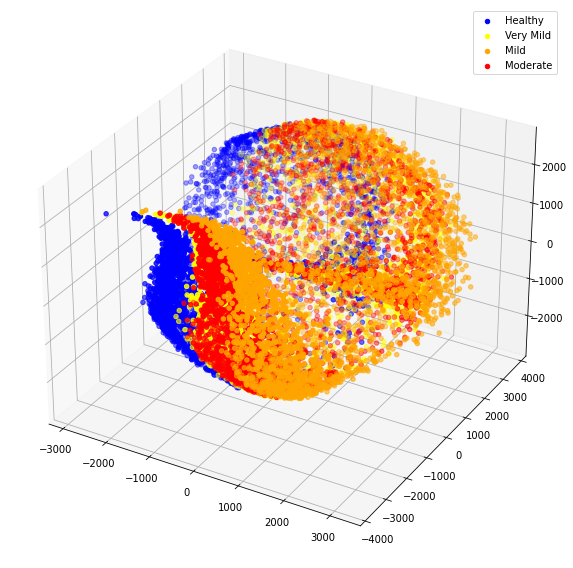

In [53]:
import pandas as pd
fig = plt.figure()
titles = ['Healthy',"Very Mild",'Mild','Moderate']
yt = ['Real','Synthetic']

for_pca = []
for aray in fake_images:
    for_pca.append(aray.flatten())

faces_pca = PCA(n_components=3)
faces_pca.fit(for_pca)
projections = faces_pca.transform(for_pca)
prj_no =[]
prj_very = []
prj_mild = []
prj_mod = []
for i,proj in enumerate(projections):
    if fake_labels[i] == 0:
        prj_no.append(proj)
    elif fake_labels[i] == 1:
        prj_very.append(proj)
    elif fake_labels[i] == 2:
        prj_mild.append(proj)
    else:
        prj_mod.append(proj)
to_plot = [np.array(prj_no),np.array(prj_very),np.array(prj_mild),np.array(prj_mod)]   

ax = fig.add_subplot(111, projection='3d')
colors = ['blue','yellow','orange','red']
for i,plot in enumerate(to_plot):
                       
    result=pd.DataFrame(plot, columns=['PCA%i' % i for i in range(3)])
    #plot_number = 141+i
    # Plot initialisation
    ax.scatter3D(result['PCA2'], result['PCA0'], -result['PCA1'],color=colors[i],label=titles[i], cmap="Set2_r", s=20)
    #if i < 4:
        #ax.set_title(titles[i],fontsize=14)
ax.legend()

fig.tight_layout()

plt.show()

# Model training, prediction, gradcam implementation 

In [4]:
fake_images = torch.tensor(fake_images)
fake_labels = torch.tensor(fake_labels)
real_images = torch.tensor(real_images)
real_labels = torch.tensor(real_labels)
test_images = torch.tensor(test_images)
test_labels = torch.tensor(test_labels)
train_images = torch.tensor(train_images)
train_labels = torch.tensor(train_labels)

tensor([0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 2, 1, 1, 0, 0, 2, 1, 3, 0, 1,
        2, 0, 0, 1, 2, 1, 2, 1, 3, 0, 0, 0, 1, 1, 0, 0, 3, 1, 1, 1, 0, 2, 1, 2,
        0, 0, 1, 0, 1, 1, 1, 1, 1, 2, 1, 1, 0, 2, 1, 0, 1, 0, 0, 1, 0, 3, 2, 2,
        2, 1, 0, 0, 0, 0, 1, 2, 0, 1, 0, 2, 1, 0, 1, 1, 1, 0, 1, 0, 0, 2, 0, 1,
        1, 0, 1, 2, 0, 0, 0, 1, 2, 1, 0, 0, 2, 1, 0, 0, 2, 0, 0, 1, 0, 0, 1, 0,
        0, 0, 0, 0, 1, 0, 0, 0])


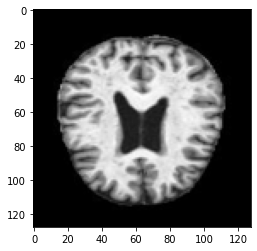

In [5]:
train_dataset = TensorDataset(train_images, train_labels)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True, drop_last=True)

test_dataset = TensorDataset(test_images, test_labels)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False, drop_last=True)
# iterate
for i, data in enumerate(test_loader):
    x, y = data  
    print(y)
    plt.imshow(x[0],cmap='gray')
    break  # we need just one batch

## Model 

In [6]:
class AryubiaNet(nn.Module):

    def __init__(self, num_classes: int = 4) -> None:
        super(AryubiaNet, self).__init__()
        self.pretrained = models.alexnet(pretrained=True)
        '''self.features = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, stride=2, padding=2),#61x61x64
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),#30x30x64
            nn.Conv2d(64, 192, kernel_size=2), #29x29x32
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),#14x14x32
            nn.Conv2d(192, 256, kernel_size=3, stride=2),#6x6x256
            nn.ReLU(inplace=True),
        )'''
        #self.avgpool = nn.AdaptiveAvgPool2d(1)
        #self.classifier = nn.Linear(256,4)
        self.classifier = nn.Sequential(
            nn.BatchNorm1d(256*3*3,eps=1e-05, momentum=0.1, affine=True),
            nn.Dropout(0.3),
            nn.Linear(256*3*3, 1280),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(1280,eps=1e-05, momentum=0.1, affine=True),
            nn.Dropout(0.2),
            nn.Linear(1280, 1280),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(1280,eps=1e-05, momentum=0.1, affine=True),
            nn.Dropout(0.4),
            nn.Linear(1280, num_classes),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.pretrained.features(x)
        #x = self.avgpool(x)
        x = torch.flatten(x, 1)
        #x = x.view(x.size(0),-1)
        #x = torch.max(x,0,keepdim=True)[0]
        x = self.classifier(x)
        return x

## Train

In [7]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

In [8]:
def train_model(model,train_loader,epoch,epochs,optimizer,current_lr,log_every):
    _ = model.train()

    y_preds = []
    y_trues = []
    losses = []
    
    
    
    for i, (image, label) in enumerate(train_loader):
        optimizer.zero_grad()
        image.unsqueeze_(0)
        image = image.repeat(3,1,1,1)
        
        image = image.transpose(0,1)
        
        label = torch.autograd.Variable(label.long())
        prediction = model.forward(image.float())

        loss = criterion(prediction, label)
        loss.backward()
        optimizer.step()

        loss_value = loss.item()
        losses.append(loss_value)


        if (i % log_every == 0) & (i > 0):
            print(
                '''[Epoch: {0} / {1} |Single batch number : {2} / {3} ]| avg train loss {4} |  lr : {5}'''.
                    format(
                    epoch + 1,
                    epochs,
                    i,
                    len(train_loader),
                    np.round(np.mean(losses), 4),
                    current_lr
                )
            )


    train_loss_epoch = np.round(np.mean(losses), 4)
    
    return train_loss_epoch

In [9]:
def evaluate_model(model, test_loader, epoch, epochs, current_lr):
    _ = model.eval()


    y_trues = []
    y_preds = []
    losses = []

    for i, (image, label) in enumerate(test_loader):
        
        image.unsqueeze_(0)
        image = image.repeat(3,1,1,1)

        image = image.transpose(0,1)

        label = torch.autograd.Variable(label.long())


        prediction = model.forward(image.float())

        loss = criterion(prediction, label)

        loss_value = loss.item()
        losses.append(loss_value)


        if (i % log_every == 0) & (i > 0):
            print(
                '''[Epoch: {0} / {1} |Single batch number : {2} / {3} ] | avg val loss {4} |  lr : {5}'''.
                    format(
                    epoch + 1,
                    epochs,
                    i,
                    len(test_loader),
                    np.round(np.mean(losses), 4),
                    current_lr
                )
            )

    val_loss_epoch = np.round(np.mean(losses), 4)
    return val_loss_epoch  

In [17]:
model = AryubiaNet()
lr = 0.0001
weights = torch.tensor([1.,3.,6.,9.])
criterion = torch.nn.CrossEntropyLoss(weight=weights)
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=0.1)
scheduler = optim.lr_scheduler.StepLR(
            optimizer, step_size=5, gamma=0.5)

epochs = 50
iteration_change_loss = 0
patience = 10
log_every = 10

best_val_loss = float('inf')

t_start_training = time.time()

for epoch in range(epochs):
    t_start = time.time()

    current_lr = get_lr(optimizer)
    train_loss = train_model(
        model, train_loader, epoch, epochs, optimizer, current_lr, log_every)
    val_loss= evaluate_model(
        model, test_loader, epoch, epochs, current_lr)
    
    scheduler.step()
    t_end = time.time()
    delta = t_end - t_start

    print("train loss : {0}  | val loss {1} | elapsed time {2} s".format(
            train_loss, val_loss,  delta))

    iteration_change_loss += 1
    print('-' * 30)
    check_accuracy(test_loader,model)

            
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        iteration_change_loss = 0
        torch.save(model.state_dict(), "synth_real.mdl")

    if iteration_change_loss == patience:
        print('Early stopping after {0} iterations without the decrease of the val loss'.
                  format(iteration_change_loss))
        break
t_end_training = time.time()
print(f'training took {t_end_training - t_start_training} s')

[Epoch: 1 / 50 |Single batch number : 10 / 133 ]| avg train loss 1.4191 |  lr : 0.0001
[Epoch: 1 / 50 |Single batch number : 20 / 133 ]| avg train loss 1.3464 |  lr : 0.0001
[Epoch: 1 / 50 |Single batch number : 30 / 133 ]| avg train loss 1.2885 |  lr : 0.0001
[Epoch: 1 / 50 |Single batch number : 40 / 133 ]| avg train loss 1.2612 |  lr : 0.0001
[Epoch: 1 / 50 |Single batch number : 50 / 133 ]| avg train loss 1.2383 |  lr : 0.0001
[Epoch: 1 / 50 |Single batch number : 60 / 133 ]| avg train loss 1.2066 |  lr : 0.0001
[Epoch: 1 / 50 |Single batch number : 70 / 133 ]| avg train loss 1.1811 |  lr : 0.0001
[Epoch: 1 / 50 |Single batch number : 80 / 133 ]| avg train loss 1.1577 |  lr : 0.0001
[Epoch: 1 / 50 |Single batch number : 90 / 133 ]| avg train loss 1.1365 |  lr : 0.0001
[Epoch: 1 / 50 |Single batch number : 100 / 133 ]| avg train loss 1.1211 |  lr : 0.0001
[Epoch: 1 / 50 |Single batch number : 110 / 133 ]| avg train loss 1.105 |  lr : 0.0001
[Epoch: 1 / 50 |Single batch number : 120 

[Epoch: 7 / 50 |Single batch number : 80 / 133 ]| avg train loss 0.568 |  lr : 5e-05
[Epoch: 7 / 50 |Single batch number : 90 / 133 ]| avg train loss 0.5688 |  lr : 5e-05
[Epoch: 7 / 50 |Single batch number : 100 / 133 ]| avg train loss 0.5687 |  lr : 5e-05
[Epoch: 7 / 50 |Single batch number : 110 / 133 ]| avg train loss 0.5687 |  lr : 5e-05
[Epoch: 7 / 50 |Single batch number : 120 / 133 ]| avg train loss 0.5695 |  lr : 5e-05
[Epoch: 7 / 50 |Single batch number : 130 / 133 ]| avg train loss 0.5676 |  lr : 5e-05
train loss : 0.5674  | val loss 5.5914 | elapsed time 81.76614809036255 s
------------------------------
Got 523 / 1152 with accuracy 45.40
[Epoch: 8 / 50 |Single batch number : 10 / 133 ]| avg train loss 0.5242 |  lr : 5e-05
[Epoch: 8 / 50 |Single batch number : 20 / 133 ]| avg train loss 0.5228 |  lr : 5e-05
[Epoch: 8 / 50 |Single batch number : 30 / 133 ]| avg train loss 0.5385 |  lr : 5e-05
[Epoch: 8 / 50 |Single batch number : 40 / 133 ]| avg train loss 0.5397 |  lr : 5e-

train loss : 0.4938  | val loss 1.3878 | elapsed time 168.96411561965942 s
------------------------------
Got 586 / 1152 with accuracy 50.87
[Epoch: 14 / 50 |Single batch number : 10 / 133 ]| avg train loss 0.5626 |  lr : 2.5e-05
[Epoch: 14 / 50 |Single batch number : 20 / 133 ]| avg train loss 0.5271 |  lr : 2.5e-05
[Epoch: 14 / 50 |Single batch number : 30 / 133 ]| avg train loss 0.5052 |  lr : 2.5e-05
[Epoch: 14 / 50 |Single batch number : 40 / 133 ]| avg train loss 0.4928 |  lr : 2.5e-05
[Epoch: 14 / 50 |Single batch number : 50 / 133 ]| avg train loss 0.4875 |  lr : 2.5e-05
[Epoch: 14 / 50 |Single batch number : 60 / 133 ]| avg train loss 0.4833 |  lr : 2.5e-05
[Epoch: 14 / 50 |Single batch number : 70 / 133 ]| avg train loss 0.4845 |  lr : 2.5e-05
[Epoch: 14 / 50 |Single batch number : 80 / 133 ]| avg train loss 0.4822 |  lr : 2.5e-05
[Epoch: 14 / 50 |Single batch number : 90 / 133 ]| avg train loss 0.4789 |  lr : 2.5e-05
[Epoch: 14 / 50 |Single batch number : 100 / 133 ]| avg tr

In [11]:
def check_accuracy(loader, model):
    num_correct = 0
    num_samples = 0
    model.eval()
    
    with torch.no_grad():
        for image, y in loader:
            image.unsqueeze_(0)
            image = image.repeat(3,1,1,1)

            image = image.transpose(0,1)
            
            scores = model(image.float())
            _, predictions = scores.max(1)
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)
        
        print(f'Got {num_correct} / {num_samples} with accuracy {float(num_correct)/float(num_samples)*100:.2f}')
        

In [18]:
check_accuracy(test_loader,model)

Got 744 / 1152 with accuracy 64.58


In [181]:
net = AryubiaNet()
for i,data in enumerate(train_loader):

    x,y = data
    x = x.repeat(3,1,1,1)
    x = x.transpose(0,1)
    prediction = net.forward(x.float())
    print(prediction),print(y)
    break

tensor([[ -4.4995,  17.0023,  -2.6579, -21.2959]], grad_fn=<AddmmBackward>)
tensor([3])


# Grad Cam

In [37]:

layer_finders = {}


def register_layer_finder(model_type):
    def register(func):
        layer_finders[model_type] = func
        return func
    return register


def visualize_cam(mask, img, alpha=0.5):
    """Make heatmap from mask and synthesize GradCAM result image using heatmap and img.
    Args:
        mask (torch.tensor): mask shape of (1, 1, H, W) and each element has value in range [0, 1]
        img (torch.tensor): img shape of (1, 3, H, W) and each pixel value is in range [0, 1]
    Return:
        heatmap (torch.tensor): heatmap img shape of (3, H, W)
        result (torch.tensor): synthesized GradCAM result of same shape with heatmap.
    """
    heatmap = (255 * mask.squeeze()).type(torch.uint8).cpu().numpy()
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    heatmap = torch.from_numpy(heatmap).permute(2, 0, 1).float().div(255)
    b, g, r = heatmap.split(1)
    heatmap = torch.cat([r, g, b]) * alpha

    result = heatmap+img[0,:,:].cpu()
    #result = result.div(result.min()).squeeze()

    return heatmap, result

@register_layer_finder('alexnet')
def find_alexnet_layer(arch, target_layer_name):
    """Find alexnet layer to calculate GradCAM and GradCAM++
    Args:
        arch: default torchvision densenet models
        target_layer_name (str): the name of layer with its hierarchical information. please refer to usages below.
            target_layer_name = 'features'
            target_layer_name = 'features_0'
            target_layer_name = 'classifier'
            target_layer_name = 'classifier_0'
    Return:
        target_layer: found layer. this layer will be hooked to get forward/backward pass information.
    """
    hierarchy = target_layer_name.split('_')

    if len(hierarchy) >= 1:
        target_layer = arch.pretrained.features[6]

    if len(hierarchy) == 2:
        target_layer = target_layer[int(hierarchy[1])]

    return target_layer

In [38]:
import torch
import torch.nn.functional as F


class GradCAM:
    """Calculate GradCAM salinecy map.
    Args:
        input: input image with shape of (1, 3, H, W)
        class_idx (int): class index for calculating GradCAM.
                If not specified, the class index that makes the highest model prediction score will be used.
    Return:
        mask: saliency map of the same spatial dimension with input
        logit: model output
    A simple example:
        # initialize a model, model_dict and gradcam
        resnet = torchvision.models.resnet101(pretrained=True)
        resnet.eval()
        gradcam = GradCAM.from_config(model_type='resnet', arch=resnet, layer_name='layer4')
        # get an image and normalize with mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)
        img = load_img()
        normed_img = normalizer(img)
        # get a GradCAM saliency map on the class index 10.
        mask, logit = gradcam(normed_img, class_idx=10)
        # make heatmap from mask and synthesize saliency map using heatmap and img
        heatmap, cam_result = visualize_cam(mask, img)
    """

    def __init__(self, arch: torch.nn.Module, target_layer: torch.nn.Module):
        self.model_arch = arch

        self.gradients = dict()
        self.activations = dict()

        def backward_hook(module, grad_input, grad_output):
            self.gradients['value'] = grad_output[0]

        def forward_hook(module, input, output):
            self.activations['value'] = output

        target_layer.register_forward_hook(forward_hook)
        target_layer.register_backward_hook(backward_hook)

    @classmethod
    def from_config(cls, arch: torch.nn.Module, model_type: str, layer_name: str):
        target_layer = layer_finders[model_type](arch, layer_name)
        return cls(arch, target_layer)

    def saliency_map_size(self, *input_size):
        device = next(self.model_arch.parameters()).device
        self.model_arch(torch.zeros(1, 3, *input_size, device=device))
        return self.activations['value'].shape[2:]

    def forward(self, input, class_idx=None, retain_graph=False):
        b, c, h, w = input.size()

        logit = self.model_arch(input)
        if class_idx is None:
            score = logit[:, logit.max(1)[-1]].squeeze()
        else:
            score = logit[:, class_idx].squeeze()

        self.model_arch.zero_grad()
        score.backward(retain_graph=retain_graph)
        gradients = self.gradients['value']
        activations = self.activations['value']
        b, k, u, v = gradients.size()

        alpha = gradients.view(b, k, -1).mean(2)
        # alpha = F.relu(gradients.view(b, k, -1)).mean(2)
        weights = alpha.view(b, k, 1, 1)

        saliency_map = (weights*activations).sum(1, keepdim=True)
        saliency_map = F.relu(saliency_map)
        saliency_map = F.upsample(saliency_map, size=(h, w), mode='bilinear', align_corners=False)
        saliency_map_min, saliency_map_max = saliency_map.min(), saliency_map.max()
        saliency_map = (saliency_map - saliency_map_min).div(saliency_map_max - saliency_map_min).data

        return saliency_map, logit

    def __call__(self, input, class_idx=None, retain_graph=False):
        return self.forward(input, class_idx, retain_graph)



In [66]:
import cv2

model.eval()

gradcam = GradCAM.from_config(model_type='alexnet', arch=model, layer_name='pretrained.features[0]')

for i,data in enumerate(train_loader):
    
    img,y = data
    print(y)
    img.unsqueeze_(0)
    img = img.repeat(3,1,1,1)
    img = img.transpose(0,1)
    #img = np.transpose(img,((1,2,0)))
    #normed_torch_img = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])(img)[None]

    #normed_img = np.float32(img) / 255

    # get an image and normalize with mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)
    #normed_img = normalizer(img)
    # get a GradCAM saliency map on the class index 10.
    mask, logit = gradcam(img.float(), class_idx=int(y))
    print(logit)
    # make heatmap from mask and synthesize saliency map using heatmap and img
    heatmap, cam_result = visualize_cam(mask, img)
    break

tensor([1], dtype=torch.int32)
tensor([[ 0.2166,  0.0939, -0.1015, -0.2061]], grad_fn=<AddmmBackward>)


In [67]:
from torchvision.utils import make_grid, save_image
img.squeeze_(0)
#img = img.repeat(3,1,1)
print(img.shape)
images =[]
images.extend([img.cpu(), heatmap, cam_result])
grid_image = make_grid(images, nrow=3)


torch.Size([3, 128, 128])


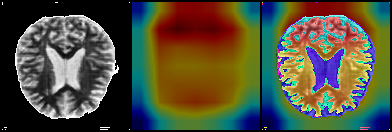

In [68]:
transforms.ToPILImage()(grid_image)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(128, 128)


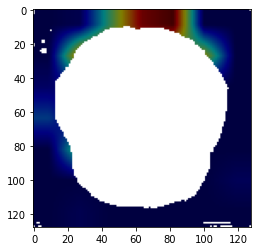

In [160]:
#cc = cam_result.cpu().numpy()[0]
print(cc.shape)
cc = np.transpose(cam_result, (1,2,0))

plt.imshow(cc)
plt.show()

In [74]:
model.pretrained.features

Sequential(
  (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
  (1): ReLU(inplace=True)
  (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (4): ReLU(inplace=True)
  (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU(inplace=True)
  (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): ReLU(inplace=True)
  (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
)